# HomeFactorAnalysis
Notebook to explore whether playing home is differente across different leagues.

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "14g").appName("HomeFactorAnalysis").getOrCreate()

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

from src.dao import dao_raw, dao_interim, columns
from src.utils import dflib, stats, pretties, plot, plot_domain, palette

In [4]:
pretties.max_data_frame_columns()

In [5]:
COLOR_HOME = palette.PALETTE_TARGET["home"]
COLOR_DRAW = palette.PALETTE_TARGET["draw"]
COLOR_AWAY = palette.PALETTE_TARGET["away"]

# Loading Data

In [6]:
ttrain = dao_interim.load_train_train_data(spark)
scores = dao_raw.load_parse_scores_data(spark)

drop_cols = columns.team_history_rating_cols + \
            columns.team_history_match_date_cols + \
            columns.team_history_league_id_cols + \
            columns.team_history_coach_colnames + \
            columns.team_history_goal_cols + \
            columns.team_history_coach_colnames

ttrain = ttrain.drop(*drop_cols)

print(f"ttrain: {dflib.shape(ttrain)}")
print(f"scores: {dflib.shape(scores)}")

ttrain: (87470, 50)
scores: (110938, 3)


In [7]:
ttrain = scores.select(["id", "score"]).join(ttrain, on="id", how="inner")
print(f"train: {dflib.shape(ttrain)}")

train: (87470, 51)


In [8]:
basic_cols = ['id', 'score', 'target', 'home_team_name', 'away_team_name', 
              'match_date', 'league_name']

# HomeFactor

### Preparing data

In [9]:
ttrain = ttrain.withColumn("week", f.date_trunc("week", "match_date"))
ttrain = ttrain.withColumn("month", f.date_trunc("month", "match_date"))

In [10]:
stats.freq(ttrain.withColumn("league_name_null", f.col("league_name").isNull()), "league_name_null", round_n=4).show()
stats.freq(ttrain.withColumn("league_id_null", f.col("league_id").isNull()), "league_id_null", round_n=4).show()

+----------------+--------+--------+
|league_name_null|Absolute|Relative|
+----------------+--------+--------+
|           false|   87469|     1.0|
|            true|       1|     0.0|
+----------------+--------+--------+

+--------------+--------+--------+
|league_id_null|Absolute|Relative|
+--------------+--------+--------+
|         false|   87470|     1.0|
+--------------+--------+--------+



### Checking HOME victory over time

+------+--------+--------+
|target|Absolute|Relative|
+------+--------+--------+
|  home|   38109|  0.4357|
|  draw|   21562|  0.2465|
|  away|   27799|  0.3178|
+------+--------+--------+



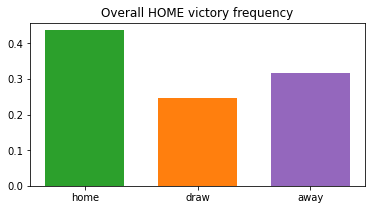

In [11]:
freq_target = stats.freq(ttrain, "target", round_n=4).orderBy(f.when(f.col("target") == "home", 1).when(f.col("target") == "draw", 2).when(f.col("target") == "away", 3))
freq_target.show()
plot.bar(freq_target, x="target", y="Relative", title="Overall HOME victory frequency", 
         color=[COLOR_HOME, COLOR_DRAW, COLOR_AWAY], figsize=(6,3))

### Checking HOME victory per league

In [12]:
n_matches = ttrain.groupBy("league_name").agg(f.count("*").alias("n_matches"))
target_freq = stats.groupby_freq(ttrain, groupby_cols="league_name", freq_on_col="target", round_n=4)
home_freq = target_freq.filter(f.col("target") == "home")
home_freq = n_matches.join(home_freq, on="league_name", how="right")

print("sample")
home_freq.limit(5).show()

sample
+-----------------+---------+------+--------+--------+
|      league_name|n_matches|target|Absolute|Relative|
+-----------------+---------+------+--------+--------+
|         1. Deild|       75|  home|      36|    0.48|
|   1. Deild Women|       68|  home|      29|  0.4265|
|      1. Division|      249|  home|     114|  0.4578|
|1. Division Women|       26|  home|      13|     0.5|
|           1. HNL|      198|  home|      94|  0.4747|
+-----------------+---------+------+--------+--------+



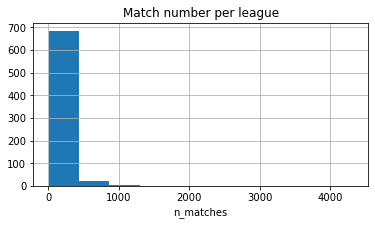

Top 6 leagues with more match records
+----------------+---------+
|     league_name|n_matches|
+----------------+---------+
|  Premier League|     4326|
| Club Friendlies|     3537|
|Primera Division|     1926|
|    Super League|     1233|
|         3. Liga|      924|
|         Ligue 1|      915|
+----------------+---------+

Summary of n_matches
+---+----+------+----+----+------+---------+
|min|q_25|median|q_75| max|  mean|   column|
+---+----+------+----+----+------+---------+
|  1|  18|    59| 150|4326|122.68|n_matches|
+---+----+------+----+----+------+---------+



In [13]:
plot.hist(n_matches, "n_matches", title="Match number per league")
print("Top 6 leagues with more match records")
n_matches.sort("n_matches", ascending=False).limit(6).show()
print("Summary of n_matches")
stats.describe(n_matches, "n_matches", round_n=4).show()

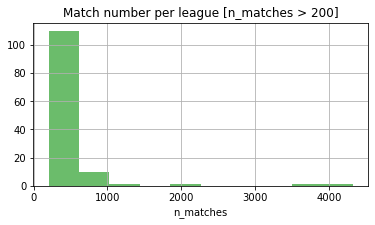

+---+----+------+----+----+------+---------+
|min|q_25|median|q_75| max|  mean|   column|
+---+----+------+----+----+------+---------+
|203| 242|   296| 377|4326|424.11|n_matches|
+---+----+------+----+----+------+---------+



In [14]:
min_n_matches = 200
home_freq_gte_n = home_freq.filter(f.col("n_matches") >= min_n_matches)

plot.hist(home_freq_gte_n, "n_matches", title=f"Match number per league [n_matches > {min_n_matches}]", color=COLOR_HOME, alpha=0.7)
stats.describe(home_freq_gte_n, "n_matches", round_n=4).show()

#### <font color=black>HOME victory frequency [n_matches > 200]</font>

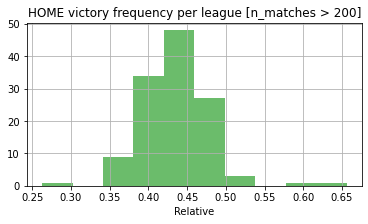

+----+----+------+----+----+----+--------+
| min|q_25|median|q_75| max|mean|  column|
+----+----+------+----+----+----+--------+
|0.26| 0.4|  0.43|0.46|0.66|0.43|Relative|
+----+----+------+----+----+----+--------+



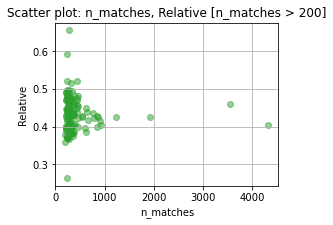

In [15]:
pretties.md(f"HOME victory frequency [n_matches > {min_n_matches}]", size="####")
plot.hist(home_freq_gte_n, "Relative", title=f"HOME victory frequency per league [n_matches > {min_n_matches}]", 
          bins=10, color=COLOR_HOME, alpha=0.7)
stats.describe(home_freq_gte_n, "Relative", round_n=4).show()
plot.scatter(home_freq_gte_n, "n_matches", "Relative", title=f"Scatter plot: n_matches, Relative [n_matches > {min_n_matches}]", color=COLOR_HOME, alpha=0.5, figsize=(4,3))

#### Notes
There is pretty simetric distribution of the relative frequency for leagues with more than 200 matches. <br>
Its mean and median values are 0.43.

### Checking HOME victory per league, over time

In [16]:
time_resolution = "month"

n_matches_dt = ttrain.groupBy(["league_name", time_resolution]).agg(f.count("*").alias("n_matches"))
target_freq_dt = stats.groupby_freq(ttrain, groupby_cols=["league_name", time_resolution], freq_on_col="target", round_n=4)

home_freq_dt = target_freq_dt.filter(f.col("target") == "home")
home_freq_dt = n_matches_dt.join(home_freq_dt, on=["league_name", time_resolution], how="right").sort("Relative")

print("sample")
home_freq_dt.limit(5).show()

sample
+----------------+-------------------+---------+------+--------+--------+
|     league_name|              month|n_matches|target|Absolute|Relative|
+----------------+-------------------+---------+------+--------+--------+
|   Hungarian Cup|2020-09-01 00:00:00|       16|  home|       1|  0.0625|
|   Hungarian Cup|2021-02-01 00:00:00|       15|  home|       1|  0.0667|
|     Finland Cup|2020-06-01 00:00:00|       14|  home|       1|  0.0714|
|      League Cup|2019-12-01 00:00:00|       14|  home|       1|  0.0714|
|Segunda División|2021-02-01 00:00:00|       12|  home|       1|  0.0833|
+----------------+-------------------+---------+------+--------+--------+



In [17]:
print(f"League with min relative frequency [n_matches > {min_n_matches}]")
home_freq_gte_n.sort("Relative").limit(2).show()
print(f"League with max relative frequency [n_matches > {min_n_matches}]")
home_freq_gte_n.sort("Relative", ascending=False).limit(2).show()

League with min relative frequency [n_matches > 200]
+-----------------+---------+------+--------+--------+
|      league_name|n_matches|target|Absolute|Relative|
+-----------------+---------+------+--------+--------+
|     Copa Del Rey|      236|  home|      62|  0.2627|
|Tipico Bundesliga|      203|  home|      73|  0.3596|
+-----------------+---------+------+--------+--------+

League with max relative frequency [n_matches > 200]
+-------------------+---------+------+--------+--------+
|        league_name|n_matches|target|Absolute|Relative|
+-------------------+---------+------+--------+--------+
|               Npfl|      276|  home|     181|  0.6558|
|Liga De Futbol Prof|      240|  home|     142|  0.5917|
+-------------------+---------+------+--------+--------+



In [18]:
home_freq_gte_n.limit(5).show()

+------------------+---------+------+--------+--------+
|       league_name|n_matches|target|Absolute|Relative|
+------------------+---------+------+--------+--------+
|      Youth League|      345|  home|     171|  0.4957|
|           Serie A|      849|  home|     363|  0.4276|
| Serie D: Girone C|      256|  home|      95|  0.3711|
|          National|      268|  home|     105|  0.3918|
|Spain Youth League|      372|  home|     170|   0.457|
+------------------+---------+------+--------+--------+



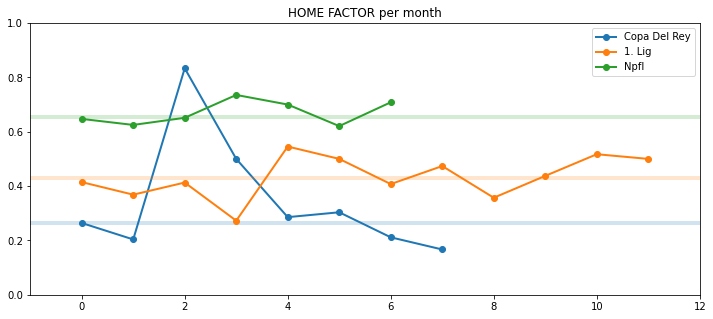

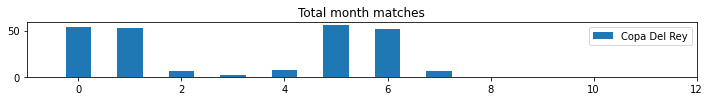

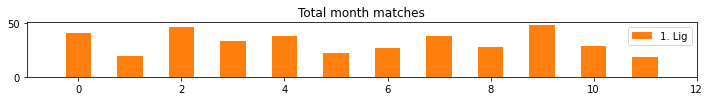

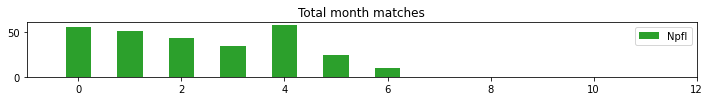

In [19]:
plot_domain.plot_home_factor_over_time(df_time=home_freq_dt, 
                                       df_total=home_freq_gte_n, 
                                       df_n_matches_time=n_matches_dt, 
                                       plot_rankings=[1, 62, home_freq_gte_n.count()])

#### Notes
It seems that some leagues have their homefactor boundaries. <br>
Some of them seem to be roughly steady over time (months) like NPFL and Copa Del Rey. NPFL have huge variation in the 3rd month due to the few number of matches, as expected by the Law of Large Numbers (few observations doesn't really match the frequent pattern). <br>
<br>
Copa Del Rey seems to have a very unexpected home_factor: around 26%.<br>
It may be so low due to its nature, in the beggining of the league, the stronger teams play in a single match as AWAY team, visiting the weaker team. For example, Linares 1 x 2 Barcelona in 2022/05/01.

# Is home_factor from train_train very differente from train_valid datasets?

In [20]:
from src.ml.transformers import HomeFactorTransformer
from scipy.stats import shapiro, ttest_rel, ttest_ind, wilcoxon, norm
import operator

In [21]:
ttrain_transformed = HomeFactorTransformer().transform(dao_interim.load_train_train_data(spark))\
    .select(["league_id", "league_name", "home_factor", "draw_factor", "n_matches"]).dropDuplicates(["league_id"])

tvalid_transformed = HomeFactorTransformer().transform(dao_interim.load_train_valid_data(spark))\
    .select(["league_id", "league_name", "home_factor", "draw_factor", "n_matches"]).dropDuplicates(["league_id"])

ttrain_transformed = dflib.append_suffix_cols(ttrain_transformed, ["home_factor", "draw_factor"], "_tt")
tvalid_transformed = dflib.append_suffix_cols(tvalid_transformed, ["home_factor", "draw_factor"], "_tv")

print("ttrain_transformed:", dflib.shape(ttrain_transformed))
print("tvalid_transformed:", dflib.shape(tvalid_transformed))
print()
print("Dropping leagues with less than 10 matches")
ttrain_transformed = ttrain_transformed.filter(f.col("n_matches") >= 10)
tvalid_transformed = tvalid_transformed.filter(f.col("n_matches") >= 10)
print("ttrain_transformed:", dflib.shape(ttrain_transformed))
print("tvalid_transformed:", dflib.shape(tvalid_transformed))

HomeFactorTransformer
HomeFactorTransformer
ttrain_transformed: (841, 5)
tvalid_transformed: (567, 5)

Dropping leagues with less than 10 matches
ttrain_transformed: (695, 5)
tvalid_transformed: (437, 5)


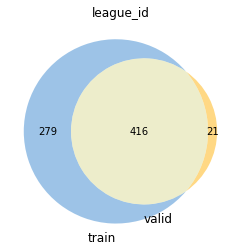

,train exclusive,intersection,valid exclusive
relative_freq,0.3897,0.581,0.0293
absolute_freq,279.0000,416.000,21.0000


In [22]:
plot.venn(ttrain_transformed, tvalid_transformed, on_colnames=["league_id"], 
          title="league_id", labels=["train", "valid"])

#### Notes
Around 95% of the leagues in train_valid dataset is present in train_train dataset. <br>
It can be applied a paired t-test in order to check home_factor_consistency.

## Paired T-Test for home_factor and draw_factor

In [23]:
paired_transformed = ttrain_transformed.join(tvalid_transformed.drop(*["league_name"]), on="league_id", 
                                             how="inner").dropna(how="any", 
                                                               subset=["league_id", "home_factor_tt", 
                                                                       "home_factor_tv", "draw_factor_tt", 
                                                                       "draw_factor_tv"])
print(dflib.shape(paired_transformed))

home_factor_paired = dflib.df_to_dict(paired_transformed, ["home_factor_tt", "home_factor_tv"])
draw_factor_paired = dflib.df_to_dict(paired_transformed, ["draw_factor_tt", "draw_factor_tv"])

(412, 8)


#### Checking Normality with Shapiro Test

In [24]:
diff_home_factor = []
diff_draw_factor = []

for i in range(paired_transformed.count()):
    diff_home_factor.append(home_factor_paired['home_factor_tv'][i] - home_factor_paired['home_factor_tt'][i])
    diff_draw_factor.append(draw_factor_paired['draw_factor_tt'][i] - draw_factor_paired['draw_factor_tv'][i])

diff_home_factor_norm_test = shapiro(diff_home_factor)
diff_draw_factor_norm_test = shapiro(diff_draw_factor)

print("Normality Test (Shapiro)")
print("\tpvalues")
print(f"\thome_factor diff: {diff_home_factor_norm_test.pvalue}")
print(f"\tdraw_factor diff: {diff_draw_factor_norm_test.pvalue}")

Normality Test (Shapiro)
	pvalues
	home_factor diff: 7.859883299765613e-10
	draw_factor diff: 0.004994266666471958


#### Notes
None of the samples for `home_factor` and `draw_factor` for both train_train and train_valid datasets follow a Normal/Gaussian distribution. <br>
It is needed to perform a non-parametric means equivalence test, Wilcoxon test it is best suitable than T-Test.

In [25]:
print("home_factor")
print("wilcoxon:", wilcoxon(diff_home_factor))

home_factor
wilcoxon: WilcoxonResult(statistic=39658.5, pvalue=0.2336413868509547)


In [26]:
print("draw_factor")
print("wilcoxon:", wilcoxon(diff_draw_factor))

draw_factor
wilcoxon: WilcoxonResult(statistic=38653.0, pvalue=0.1984507865940205)


# Conclusions
Wilcoxon null-hypothesis say the both samples comes from the same population. <br>
For both `home_factor` and `draw_factor` it failed to reject the null-hypothesis (due to p-value > 0.05). <br>
<br>
It can be concluded that there is enough evidences that `home_factor` and `draw_factor` paired for both `train_train` and `train_valid` datasets have equivalence, i.e., their means come from the same distribution.<br>
So, considering these factors steady across leagues, their calculated values for known targets can be considered for also the `test` dataset.

In [27]:
#saving home_factor and draw_factor for whole train dataset
dao_interim.save_home_factor_whole_train(HomeFactorTransformer().transform(dao_raw.load_parse_train_data(spark=spark)))

HomeFactorTransformer
